In [9]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [10]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

matplotlib==3.9.0
numpy==1.26.4
pandas==2.2.2
seaborn==0.13.2


In [11]:
# 文件路径
file_path = 'yeardata/GOOGL_2023.csv'
df = pd.read_csv(file_path)
stock_name = file_path.split('/')[-1].split('_')[0]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,89.589996,91.050003,88.519997,89.120003,89.017838,28131200
1,2023-01-04,90.349998,90.650002,87.269997,88.080002,87.979027,34854800
2,2023-01-05,87.470001,87.570000,85.900002,86.199997,86.101181,27194400
3,2023-01-06,86.790001,87.690002,84.860001,87.339996,87.239868,41381500
4,2023-01-09,88.360001,90.050003,87.860001,88.019997,87.919090,29003900


In [12]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 1000, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [13]:
import csv
import os
import numpy as np

class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money, stock_name):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.stock_name = stock_name
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        
        # 初始化一个列表来存储买卖记录
        self.trade_records = []
        # 确保文件夹存在
        self.folder_name = 'selldata'
        if not os.path.exists(self.folder_name):
            os.makedirs(self.folder_name)
        # 创建CSV文件并写入标题行
        self.file_path = f"{self.folder_name}/{self.stock_name}_trade_records.csv"
        with open(self.file_path, mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=['day', 'operation', 'price', 'investment', 'total balance'])
            writer.writeheader()

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t] * 10:
                inventory.append(self.trend[t])
                starting_money -= self.trend[t] * 10
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t] * 10

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every=checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] * 10:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t] * 10
                states_buy.append(t)
                print('day %d: buy 10 units at price %f, total balance %f'% (t, self.trend[t], initial_money))
                buy_record = {
                    'day': t,
                    'operation': 'buy',
                    'price': self.trend[t],
                    'investment': 0,
                    'total balance': initial_money
                }
                self.trade_records.append(buy_record)
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t] * 10
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                sell_record = {
                    'day': t,
                    'operation': 'sell',
                    'price': self.trend[t],
                    'investment': invest,
                    'total balance': initial_money
                }
                self.trade_records.append(sell_record)
                print(
                    'day %d, sell 10 units at price %f, investment %f %%, total balance %f'
                    % (t, self.trend[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        
        # 将交易记录追加保存到CSV文件
        with open(self.file_path, mode='a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=['day', 'operation', 'price', 'investment', 'total balance'])
            for record in self.trade_records:
                writer.writerow(record)
        
        return states_buy, states_sell, total_gains, invest

In [14]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 100000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money,
              stock_name = stock_name)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 1.382700
iter 20. reward: 2.837400
iter 30. reward: 5.892599
iter 40. reward: 4.912699
iter 50. reward: 4.996200
iter 60. reward: 5.622999
iter 70. reward: 5.505199
iter 80. reward: 6.228299
iter 90. reward: 6.487000
iter 100. reward: 5.521099
iter 110. reward: 6.031499
iter 120. reward: 5.966000
iter 130. reward: 4.255399
iter 140. reward: 3.638400
iter 150. reward: 7.368999
iter 160. reward: 8.231000
iter 170. reward: 6.763300
iter 180. reward: 9.347900
iter 190. reward: 10.136899
iter 200. reward: 10.335799
iter 210. reward: 10.564700
iter 220. reward: 7.265700
iter 230. reward: 7.315999
iter 240. reward: 9.865900
iter 250. reward: 8.453599
iter 260. reward: 8.807099
iter 270. reward: 8.070299
iter 280. reward: 9.132299
iter 290. reward: 8.511100
iter 300. reward: 8.903099
iter 310. reward: 7.592199
iter 320. reward: 7.663100
iter 330. reward: 9.547900
iter 340. reward: 8.135100
iter 350. reward: 9.547000
iter 360. reward: 9.643400
iter 370. reward: 9.919100
iter 38

In [15]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 0: buy 10 units at price 89.120003, total balance 99108.799973
day 1: buy 10 units at price 88.080002, total balance 98227.999954
day 2: buy 10 units at price 86.199997, total balance 97365.999985
day 5: buy 10 units at price 88.419998, total balance 96481.800003
day 6, sell 10 units at price 91.519997, investment 2.692991 %, total balance 97396.999969
day 7: buy 10 units at price 91.129997, total balance 96485.699997
day 9: buy 10 units at price 91.290001, total balance 95572.799988
day 10: buy 10 units at price 91.120003, total balance 94661.599960
day 11: buy 10 units at price 93.050003, total balance 93731.099930
day 12, sell 10 units at price 98.019997, investment 11.285189 %, total balance 94711.299896
day 13: buy 10 units at price 99.790001, total balance 93713.399887
day 14: buy 10 units at price 97.699997, total balance 92736.399918
day 15: buy 10 units at price 95.220001, total balance 91784.199905
day 17: buy 10 units at price 99.370003, total balance 90790.499878
day 18

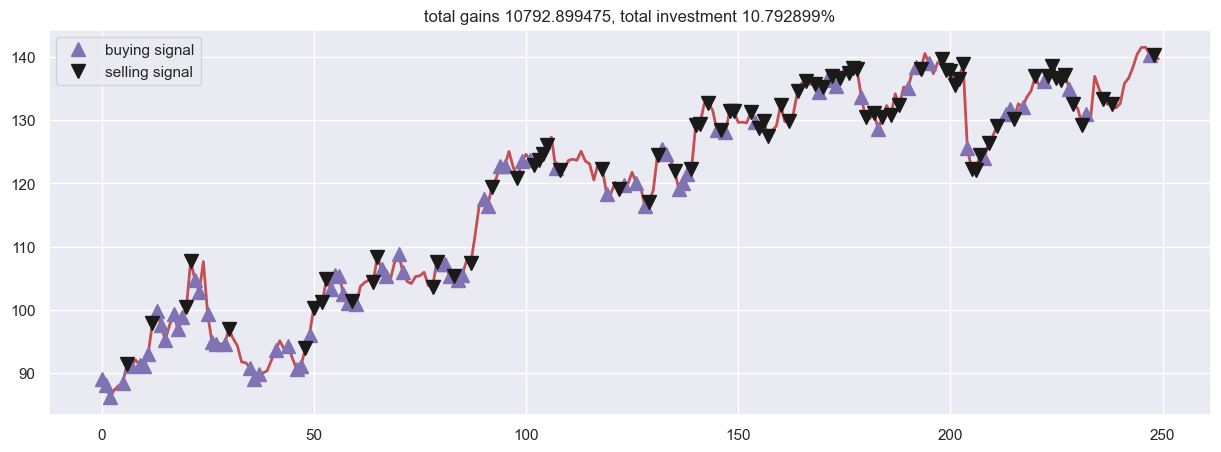

In [16]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()